In [1]:
# Importing libraries and functions from libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [2]:
# Reading csv file into a dataframe and then printing the dataframe and its shape
df = pd.read_csv("genres.csv", low_memory = False) 
# Setting low_memory to false because I'm getting a warning that I have different data types even though that's fine

# Dropping obviously useless features like urls, audio file types, etc.
useless_features = ['type', 'id','uri','track_href','analysis_url','song_name','Unnamed: 0','title']
df = df.drop(columns = useless_features)

print("Dataframe Shape:", df.shape)
df


Dataframe Shape: (42305, 14)


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,genre
0,0.831,0.814,2,-7.364,1,0.4200,0.059800,0.013400,0.0556,0.3890,156.985,124539,4,Dark Trap
1,0.719,0.493,8,-7.230,1,0.0794,0.401000,0.000000,0.1180,0.1240,115.080,224427,4,Dark Trap
2,0.850,0.893,5,-4.783,1,0.0623,0.013800,0.000004,0.3720,0.0391,218.050,98821,4,Dark Trap
3,0.476,0.781,0,-4.710,1,0.1030,0.023700,0.000000,0.1140,0.1750,186.948,123661,3,Dark Trap
4,0.798,0.624,2,-7.668,1,0.2930,0.217000,0.000000,0.1660,0.5910,147.988,123298,4,Dark Trap
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42300,0.528,0.693,4,-5.148,1,0.0304,0.031500,0.000345,0.1210,0.3940,150.013,269208,4,hardstyle
42301,0.517,0.768,0,-7.922,0,0.0479,0.022500,0.000018,0.2050,0.3830,149.928,210112,4,hardstyle
42302,0.361,0.821,8,-3.102,1,0.0505,0.026000,0.000242,0.3850,0.1240,154.935,234823,4,hardstyle
42303,0.477,0.921,6,-4.777,0,0.0392,0.000551,0.029600,0.0575,0.4880,150.042,323200,4,hardstyle


In [3]:
# Gaining information for feature selection on all remaining features vs. our target feature, 'genre'
X = df.drop('genre', axis = 1)
y = df['genre']

anova_corr, p_values = f_classif(X, y)

anova_corr_df = pd.DataFrame({'Feature': X.columns, 'ANOVA Correlation': anova_corr, 'p-value': p_values})

anova_corr_df


,Feature,ANOVA Correlation,p-value
0,danceability,1866.378215,0.000000e+00
1,energy,1972.714458,0.000000e+00
2,key,27.666341,1.351100e-73
3,loudness,1425.259885,0.000000e+00
4,mode,90.763628,1.060033e-258
5,speechiness,1104.793811,0.000000e+00
6,acousticness,733.002076,0.000000e+00
7,instrumentalness,4161.206522,0.000000e+00
8,liveness,262.479788,0.000000e+00
9,valence,1078.975997,0.000000e+00


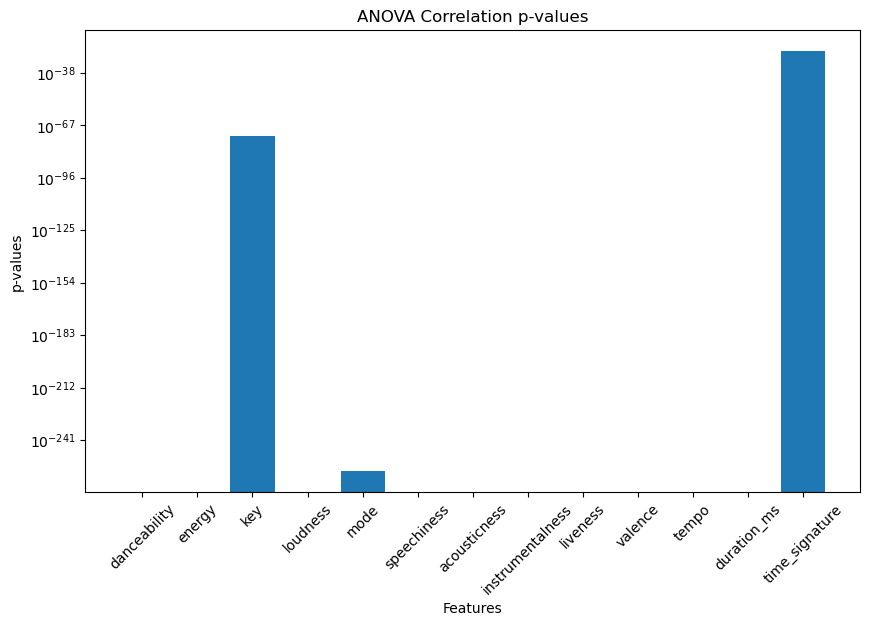

In [4]:
# Plotting out p-value obtained from each feature on a bar graph for visualization
plt.figure(figsize=(10, 6))

plt.bar(anova_corr_df['Feature'].tolist(), anova_corr_df['p-value'].tolist())
plt.xticks(rotation=45) # Avoiding overlap on feature names
plt.yscale('log') # Utilizing this scale since some p-values are too low and difficult to see on bar graph
plt.xlabel('Features')
plt.ylabel('p-values')
plt.title('ANOVA Correlation p-values')

plt.show()

In [5]:
'''Performing feature selection through an alpha value to select features by setting a threshold 
    for p-value acceptability'''
alpha = 0.01 #Significance level of 1%

selected_features = []
for i in range(len(p_values)):
    if p_values[i] < alpha:
        selected_features.append(X.columns[i])

print("Selected Features:")
print(selected_features)


Selected Features:
['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']


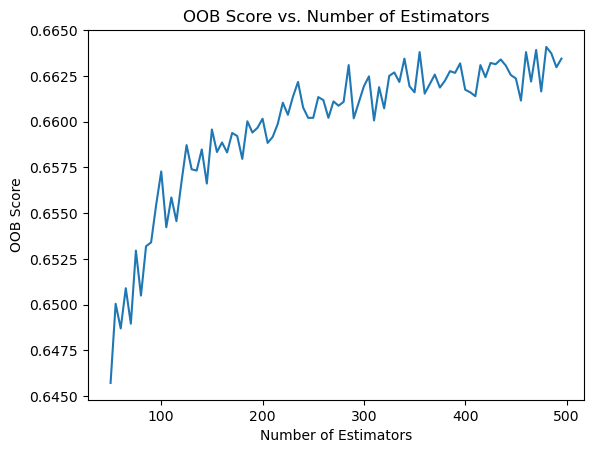

In [46]:
# Figuring out best hyperparameter for 'n' in Random Forests model
n_estimators_values = []
oob_scores = []

for n in range(50,500,5): 
    # Set number of trees from 50 to 500 since I wanted to avoid warnings from too low of n_estimators
    n_estimators_values.append(n)
    genre_rf_model = RandomForestClassifier(n_estimators = n, bootstrap = True, oob_score = True)
    genre_rf_model.fit(X, y)
    oob_scores.append(genre_rf_model.oob_score_)

plt.plot(n_estimators_values, oob_scores)
plt.xlabel('Number of Estimators')
plt.ylabel('OOB Score')
plt.title('OOB Score vs. Number of Estimators')
plt.show()

In [48]:
# Found best 'n' for number of forests in Music Genre Random Forest model, and now testing against our data sets
best_oob_index = np.argmax(oob_scores)
best_n_estimator = n_estimators_values[best_oob_index]
print("Best n_estimator:", best_n_estimator)

improved_genre_model = RandomForestClassifier(n_estimators = best_n_estimator, bootstrap = True)
improved_genre_model.fit(X, y)

y_pred = improved_genre_model.predict(X)

Best n_estimator: 480


In [49]:
# Comparison for True Genre values vs Predicted Genre Values
comparison = pd.DataFrame({'Actual value for Train Set': y, 'Predicted value for Train Set': y_pred})
comparison

,Actual value for Train Set,Predicted value for Train Set
0,Dark Trap,Dark Trap
1,Dark Trap,Dark Trap
2,Dark Trap,Dark Trap
3,Dark Trap,Trap Metal
4,Dark Trap,Underground Rap
...,...,...
42300,hardstyle,hardstyle
42301,hardstyle,hardstyle
42302,hardstyle,hardstyle
42303,hardstyle,hardstyle


In [52]:
# Accuracy Score of Prediction values
accuracy = accuracy_score(y, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9277626758066423
